A notebook to test the pypropeller tool.

The propeller tool was developed originally for R and is integrated in the package "speckle" (Belinda Phipson, Choon Boon Sim, Enzo R Porrello, Alex W Hewitt, Joseph Powell, Alicia Oshlack).

Since propeller uses functionalities from the package "limma", these functions has been reimplemented to be used by pypropeller.

The dataset used in this tutorial is the same used in the "speckle" vignette.

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pypropeller import pypropeller
from pypropeller.linear_model import *
from pypropeller.get_transformed_props import *

# Load anndata
* anndata.obs table has to include 3 columns:
    - condition
    - sample
    - clusters/celltypes

In [2]:
adata = sc.read_h5ad('/mnt/workspace/yalayou/scATAC_seq/framework/data/thesis/data/propeller_tutorial.h5ad')
adata

/home/yalayou/.conda/envs/sctoolbox/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 2802 × 13575
    obs: 'sample', 'group', 'cluster'
    uns: 'color_set', 'infoprocess'

In [3]:
adata.obs

,sample,group,cluster
CELL_000001,S1,10x,HCC827
CELL_000002,S1,10x,H1975
CELL_000003,S1,10x,HCC827
CELL_000004,S1,10x,HCC827
CELL_000005,S1,10x,HCC827
...,...,...,...
CELL_000140,S6,dropseq,H2228
CELL_000233,S6,dropseq,H1975
CELL_000082,S6,dropseq,HCC827
CELL_000012,S6,dropseq,H1975


# Run pypropeller
* You can use the wrapper function "pypropeller". 
#### Parameters are:
    - anndata object
    - clusters: name of clusters/celltypes column in obs table
    - sample: name of sample column in obs table
    - cond: name of condition/group column in obs table
    - transform: type of transformation; logit or arcsin, default is logit

In [4]:
out = pypropeller.pypropeller(adata, clusters_col='cluster', samples_col='sample', conds_col='group', transform='logit')
out

There are more than 2 conditions. ANOVA will be performed...
Done!


,Baseline_props,Mean_props_10x,Mean_props_celseq,Mean_props_dropseq,F_statistics,p_values,Adjusted_p_values
Clusters,,,,,,,
H1975,0.357959,0.339246,0.394161,0.388889,3.994837,0.018410,0.050034
H2228,0.332263,0.348115,0.297445,0.311111,3.400526,0.033356,0.050034
HCC827,0.309779,0.312639,0.308394,0.300000,0.207697,0.812453,0.812453


## Visualisation of estimated mean_props for each condition in each cluster

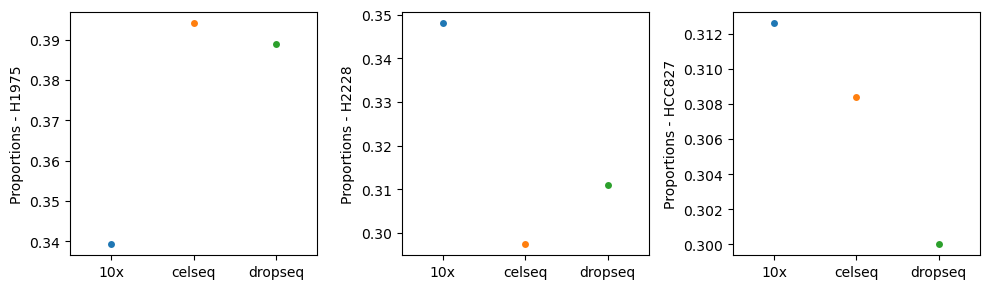

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
for i, cluster in enumerate(out.T.columns):
    
    ax = sns.stripplot(data=out.T.iloc[1:4,:], y=cluster, x=['10x','celseq','dropseq'], hue=['10x','celseq','dropseq'], legend=False, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - '+cluster)

fig.tight_layout()

## Propeller workflow

* The pypropeller function is a wrapper function, to have more controls you can perform the steps below and see how the pypropeller
function works

#### Get proportions and transformed proportions using `get_transformed_props` function

In [6]:
counts, props, prop_trans = get_transformed_props(adata, sample_col='sample', cluster_col='cluster', transform='logit')

In [7]:
counts

cluster,H1975,H2228,HCC827
sample,,,
S1,313,315,274
S2,299,313,290
S3,114,81,79
S4,102,82,90
S5,92,65,68
S6,83,75,67


In [8]:
props

cluster,H1975,H2228,HCC827
sample,,,
S1,0.347007,0.349224,0.303769
S2,0.331486,0.347007,0.321508
S3,0.416058,0.295620,0.288321
S4,0.372263,0.299270,0.328467
S5,0.408889,0.288889,0.302222
S6,0.368889,0.333333,0.297778


In [9]:
prop_trans

cluster,H1975,H2228,HCC827
sample,,,
S1,-0.632323,-0.622568,-0.829180
S2,-0.701460,-0.632323,-0.746761
S3,-0.340830,-0.867255,-0.902358
S4,-0.523429,-0.849892,-0.715006
S5,-0.370631,-0.899354,-0.835761
S6,-0.537998,-0.693147,-0.856777


In [10]:
baseline_props = adata.obs['cluster'].value_counts()/adata.obs.shape[0]
baseline_props

H1975     0.357959
H2228     0.332263
HCC827    0.309779
Name: cluster, dtype: float64

#### Create design matrix using `create_design` function. The matrix has samples as rows and conditions and columns, whith 1s and 0s to specify which condition belongs to which sample (independent variables). The design matrix will be used as the X matrix in the linear model fit.
##### Parameters:
    - data: anndata object, or a pandas dataframe
    - samples: name of samples column
    - conds: name of conditions/groups column

In [11]:
design = create_design(data=adata, samples='sample', conds='group')
design

Group,10x,celseq,dropseq
Sample,,,
S1,1,0,0
S2,1,0,0
S3,0,1,0
S4,0,1,0
S5,0,0,1
S6,0,0,1


In [12]:
# for anova -> more than 2 conditions/groups
# The coef parameter specify the columns in the design matrix containing conditions of interest
# that you want to compare
coef = np.arange(len(design.columns))
coef

array([0, 1, 2])

#### Since we have more than 2 conditions, use the function `anova` to compare. If you have two conditions or want to only compare two, then specify a contras variable `cont = [1, -1]` with 1 and -1 match the columns of the design matrix with two conditions you want to compare. if the design matrix has more than two conditions but you only want to compare two, put 1 and -1 where they match the columns of interest and fill the rest with 0s, in this case, to compare 10x and celseq: `cont = [1, -1, 0]`

In [13]:
pypropeller.anova(props, prop_trans, design, coef, robust=True)

,Mean_props_10x,Mean_props_celseq,Mean_props_dropseq,F_statistics,p_values,Adjusted_p_values
Clusters,,,,,,
H1975,0.339246,0.394161,0.388889,3.994837,0.018410,0.050034
H2228,0.348115,0.297445,0.311111,3.400526,0.033356,0.050034
HCC827,0.312639,0.308394,0.300000,0.207697,0.812453,0.812453


## Visualize proportions of each sample in each cluster

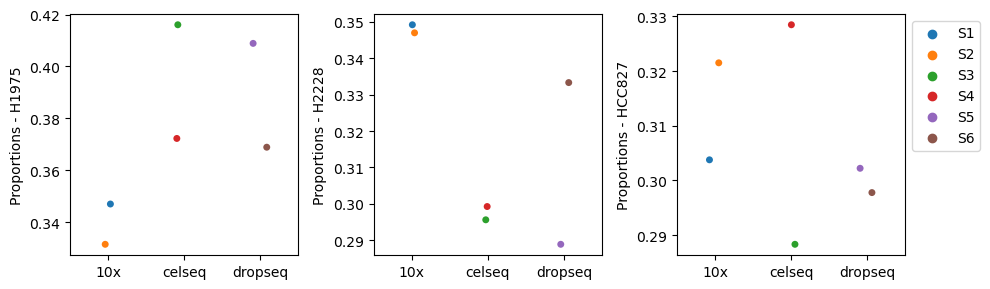

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=len(out.index), figsize=(10, 3))
axes = axes.flatten()
x = np.repeat(['10x','celseq','dropseq'], 2)
for i, cluster in enumerate(props.columns):
    legend = True if i == len(axes) -1 else False
    ax = sns.stripplot(data=props, y=cluster, x=x, hue='sample', legend=legend, jitter=True, ax=axes[i])
    ax.set(ylabel='Proportions - ' + cluster)

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

#### Additionally, you can specify cofactors of interest and add them to the design matrix, either specify cofactor columns in the adata.obs as parameter `cofactor` to the `create_design` function, or add it manually to the design matrix. In our case, we will add pair information that specifies which sample is a replicate

In [15]:
X = design.iloc[:,coef]
N = len(X)  # number of samples
p = len(X.columns)  # number of conditions

In [16]:
cont = np.tile([1, 2], N//2)
new_design = design.copy()
new_design['pair'] = cont
new_design

Group,10x,celseq,dropseq,pair
Sample,,,,
S1,1,0,0,1
S2,1,0,0,2
S3,0,1,0,1
S4,0,1,0,2
S5,0,0,1,1
S6,0,0,1,2


In [17]:
# run anova, taking into account pair information
pypropeller.anova(props, prop_trans, new_design, coef, robust=True)

,Mean_props_10x,Mean_props_celseq,Mean_props_dropseq,F_statistics,p_values,Adjusted_p_values
Clusters,,,,,,
H1975,0.339246,0.394161,0.388889,7.076680,0.000845,0.002534
H2228,0.348115,0.297445,0.311111,6.023885,0.002420,0.003630
HCC827,0.312639,0.308394,0.300000,0.367926,0.692169,0.692169


In [18]:
# to compare only 10x and celseq, specify a contrast and run t_test
contr = [1,-1,0]
pypropeller.t_test(props, prop_trans, design, contr, robust=True)

,Mean_props_10x,Mean_props_celseq,Prop_ratio,t_statistics,p_values,Adjusted_p_values
Clusters,,,,,,
H1975,0.339246,0.394161,0.860680,-2.559883,0.030693,0.049133
H2228,0.348115,0.297445,1.170351,2.520252,0.032755,0.049133
HCC827,0.312639,0.308394,1.013763,0.225837,0.826373,0.826373
